In [5]:
import os
import cortex
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import nibabel as nb
import glob

In [6]:
log_dir = '/home/hpcgies1/Masters-Thesis/AttemptFour/Log/'
model = 'subject_1_and_2'

## Load Glasser

In [15]:
GLASSER_LH = "/rds/user/hpcgies1/hpc-work/NIC/NSD/nsddata/freesurfer/fsaverage/label/lh.HCP_MMP1.mgz"
GLASSER_RH = "/rds/user/hpcgies1/hpc-work/NIC/NSD/nsddata/freesurfer/fsaverage/label/rh.HCP_MMP1.mgz"
s = time.time()
glasser_lh = nb.load(GLASSER_LH).get_fdata() # 163_842 values in the range [0, 180]
glasser_rh = nb.load(GLASSER_RH).get_fdata()
print(f"load glasser masks: {(time.time() - s):.2f}")

glasser = np.vstack((glasser_lh, glasser_rh)).flatten()

print("glasser_lh", glasser_lh.shape)
print("glasser_rh", glasser_rh.shape)
print("glasser   ", glasser.shape)

glasser_lh_flat = glasser_lh.flatten()
glasser_rh_flat = glasser_rh.flatten()
glasser_indices_rh = np.array(range(len(glasser_rh_flat)))
groups_rh = []
for i in set(glasser_rh_flat):
    groups_rh.append(glasser_indices_rh[glasser_rh_flat == i])
glasser_indices_lh = np.array(range(len(glasser_lh_flat)))
groups_lh = []
for i in set(glasser_rh_flat):
    groups_lh.append(glasser_indices_lh[glasser_lh_flat == i])
groups = groups_lh[1:] + groups_rh[1:]
#groups_concat = list(map(list.__add__, groups_lh, groups_rh))
groups_lh = groups_lh[1:]
groups_rh = groups_rh[1:]
assert len(groups) == 360, "Using separate hemishere groups = 360"


load glasser masks: 0.06
glasser_lh (163842, 1, 1)
glasser_rh (163842, 1, 1)
glasser    (327684,)


## Functions

In [16]:
def load(fname):
    return np.squeeze(np.load(open(fname, "rb")), axis=-1)

def rank_transform(data):
    return np.log(data)

def get_flatmap(glasser_regions):
    cortex.add_roi
    vert = cortex.Vertex(glasser_regions, subject='fsaverage')#, vmin=-8, vmax=8)
    im, extents = cortex.quickflat.make_flatmap_image(vert)
    return im, extents

def generate_plot(data_):
    """ Generate the glasser_regions which can be converted to flatmap and plotted 
    Parameters
    ----------
        data : np.array - 1-D  (360,)
    """
    glasser_regions_lh = np.zeros(glasser_lh.shape)
    glasser_regions_rh = np.zeros(glasser_rh.shape)
    glasser_regions_lh[:] = np.NaN
    glasser_regions_rh[:] = np.NaN
    for i, g in enumerate(groups_lh):
        glasser_regions_lh[g] = data_[i]
    for i, g in enumerate(groups_rh):
        glasser_regions_rh[g] = data_[i+180]
    glasser_regions = np.vstack((glasser_regions_lh, glasser_regions_rh)).flatten() # (327684,)
    return glasser_regions


## Load Data

In [69]:
attn = load(f"{log_dir}/{model}/eval_out/attention_scores_23.npy")
print(attn.shape)

attn_sub1 = attn[0]
attn_sub2 = attn[1]
X1 = np.mean(attn_sub1, axis=(0, 1))
X2 = np.mean(attn_sub2, axis=(0, 1))

(2, 515, 15, 360)


In [41]:
attn2 = load(f"{log_dir}/subject_2_both_layer_norm/eval_out/attention_scores_25.npy")
# attn3 = load(f"{log_dir}/subject_1_layer_norm/eval_out/attention_scores_)

(515, 15, 360)

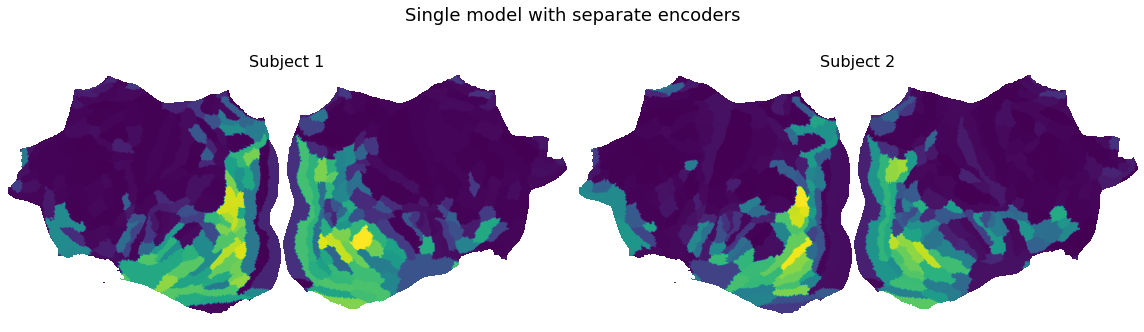

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(16,9))

ax[0].imshow(get_flatmap(generate_plot(X1))[0])
ax[0].set_title("Subject 1", fontsize=16)
ax[0].axis('off')

ax[1].imshow(get_flatmap(generate_plot(X2))[0])
ax[1].set_title("Subject 2", fontsize=16)
ax[1].axis('off')

fig.tight_layout()
plt.suptitle("Single model with separate encoders", fontsize=18)
plt.subplots_adjust(top=1.35)
plt.show()

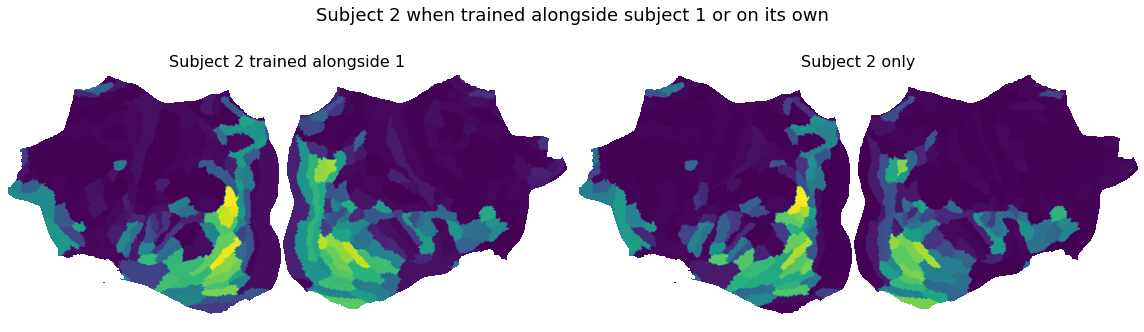

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(16,9))

ax[0].imshow(get_flatmap(generate_plot(X2))[0])
ax[0].set_title("Subject 2 trained alongside 1", fontsize=16)
ax[0].axis('off')

ax[1].imshow(get_flatmap(generate_plot(np.mean(attn2, axis=(0, 1))))[0])
ax[1].set_title("Subject 2 only", fontsize=16)
ax[1].axis('off')

fig.tight_layout()
plt.suptitle("Subject 2 when trained alongside subject 1 or on its own", fontsize=18)
plt.subplots_adjust(top=1.35)
plt.show()